# Project Title: 
# Identify Health Care Professionals Using Transfer Learning on a Pre-trained Convolutional Neural Network (Resnet18)

Author: Kelvin Tham Kum Hong 

Dated: 25 Feb 2018

## Aim

#### Importing Libraries

In [3]:
# Basics
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import time
import os
import copy

# PyTorch
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
plt.ion() # Interactive mode
%matplotlib inline

In [4]:
# Check library versions
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(scipy.__version__))
print('pytorch: {}'.format(torch.__version__))
print('torchvision: {}'.format(torchvision.__version__))

pandas: 0.21.1
numpy: 1.12.1
matplotlib: 2.1.1
seaborn: 0.8.1
scipy: 1.0.0
pytorch: 0.3.0.post4
torchvision: 0.2.0


## Transfer Learning Workflow (PyTorch)

We will do the following steps in order:
1. Loading and normalizing data (image set)
2. Create a general function to train a model
3. Create a generic function to display predictions for a few images

Using ConvNet as fixed feature extractor (achieved 100% accuracy on validation set of 45 images in 22mins): Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

### 1. Analyze and Prepare Data (Image Set)

In [33]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

data_dir = 'data/HCW'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
#image_datasets.values

use_gpu = torch.cuda.is_available()

In [6]:
print(dataset_sizes, class_names)
print(image_datasets)

{'train': 435, 'val': 100} ['doctor', 'nurse', 'patient']
{'train': <torchvision.datasets.folder.ImageFolder object at 0x116436978>, 'val': <torchvision.datasets.folder.ImageFolder object at 0x109094438>}


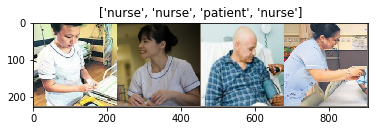

In [7]:
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid of training data
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Generic function to train a model

In [8]:
# General function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # Get the inputs
                inputs, labels = data

                # Wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 3. Generic function to display predictions for a few images

In [26]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        print("labels: {}".format(labels))
        print("outputs: {}".format(outputs))
        _, preds = torch.max(outputs.data, 1)
        print("preds: {}".format(preds))
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

### 4. ConvNet as *fixed feature extractor (Define model, loss function and optimizer) - Only train last layer

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
print(model_conv.fc)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optmized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=3)


#### 4.1 Train the model

In [28]:
# Train for first 25 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.9066 Acc: 0.5678
val Loss: 0.4891 Acc: 0.8600

Epoch 2/25
----------
train Loss: 0.7688 Acc: 0.6713
val Loss: 0.4360 Acc: 0.8500

Epoch 3/25
----------
train Loss: 0.6206 Acc: 0.7563
val Loss: 0.5519 Acc: 0.7700

Epoch 4/25
----------
train Loss: 0.5590 Acc: 0.7954
val Loss: 0.5960 Acc: 0.7400

Epoch 5/25
----------
train Loss: 0.5294 Acc: 0.7862
val Loss: 0.5060 Acc: 0.8200

Epoch 6/25
----------
train Loss: 0.5194 Acc: 0.7793
val Loss: 0.4002 Acc: 0.8400

Epoch 7/25
----------
train Loss: 0.5348 Acc: 0.7747
val Loss: 0.4117 Acc: 0.8600

Epoch 8/25
----------
train Loss: 0.4209 Acc: 0.8345
val Loss: 0.3282 Acc: 0.8600

Epoch 9/25
----------
train Loss: 0.4569 Acc: 0.8069
val Loss: 0.3512 Acc: 0.8400

Epoch 10/25
----------
train Loss: 0.4106 Acc: 0.8276
val Loss: 0.3779 Acc: 0.8700

Epoch 11/25
----------
train Loss: 0.4150 Acc: 0.8322
val Loss: 0.3433 Acc: 0.8900

Epoch 12/25
----------
train Loss: 0.4066 Acc: 0.8460
val Loss: 0.3367 Acc: 0.8600

E

In [35]:
# Train for next 25 epochs. Consider to reduce LR
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.3880 Acc: 0.8552
val Loss: 0.3324 Acc: 0.8500

Epoch 2/25
----------
train Loss: 0.3874 Acc: 0.8598
val Loss: 0.3431 Acc: 0.8400

Epoch 3/25
----------
train Loss: 0.4171 Acc: 0.8207
val Loss: 0.3407 Acc: 0.8600

Epoch 4/25
----------
train Loss: 0.3397 Acc: 0.8644
val Loss: 0.3334 Acc: 0.8600

Epoch 5/25
----------
train Loss: 0.3792 Acc: 0.8529
val Loss: 0.3642 Acc: 0.8500

Epoch 6/25
----------
train Loss: 0.4430 Acc: 0.8345
val Loss: 0.3383 Acc: 0.8500

Epoch 7/25
----------
train Loss: 0.3896 Acc: 0.8483
val Loss: 0.3486 Acc: 0.8600

Epoch 8/25
----------
train Loss: 0.4219 Acc: 0.8437
val Loss: 0.3511 Acc: 0.8600

Epoch 9/25
----------
train Loss: 0.3731 Acc: 0.8552
val Loss: 0.3652 Acc: 0.8600

Epoch 10/25
----------
train Loss: 0.3884 Acc: 0.8529
val Loss: 0.4040 Acc: 0.8500

Epoch 11/25
----------
train Loss: 0.3569 Acc: 0.8575
val Loss: 0.3439 Acc: 0.8700

Epoch 12/25
----------
train Loss: 0.3966 Acc: 0.8460
val Loss: 0.3366 Acc: 0.8700

E

#### 4.2 Visualize Results

labels: Variable containing:
 1
 1
 2
 2
[torch.LongTensor of size 4]

outputs: Variable containing:
 0.6249 -0.6040  0.1889
 0.3580  0.0709  0.9334
 0.7050 -0.6365  0.7499
-0.0426 -0.5798  0.1169
[torch.FloatTensor of size 4x3]

preds: 
 0
 2
 2
 2
[torch.LongTensor of size 4]



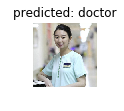

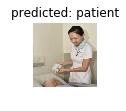

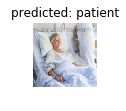

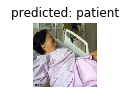

labels: Variable containing:
 2
 2
 0
 2
[torch.LongTensor of size 4]

outputs: Variable containing:
 0.8836 -0.3312  0.1498
 0.1409 -0.6647  0.5807
 0.0987 -0.2612  0.3830
 0.4763 -0.3674  0.7999
[torch.FloatTensor of size 4x3]

preds: 
 0
 2
 2
 2
[torch.LongTensor of size 4]



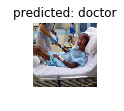

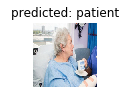

In [27]:
# Results from untrained model
visualize_model(model_conv)
plt.ioff()
plt.show()

labels: Variable containing:
 2
 2
 2
 2
[torch.LongTensor of size 4]

outputs: Variable containing:
-2.6614 -1.1108  4.7205
 0.4547  2.2576 -2.4136
-0.7468 -4.2366  7.6333
-0.2874  0.7814  0.0968
[torch.FloatTensor of size 4x3]

preds: 
 2
 1
 2
 1
[torch.LongTensor of size 4]



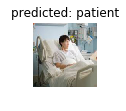

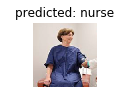

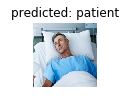

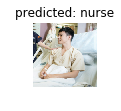

labels: Variable containing:
 0
 1
 0
 2
[torch.LongTensor of size 4]

outputs: Variable containing:
 2.4332  1.3209 -3.6477
-1.6470 -0.0199  2.7970
 1.0453  3.0325 -3.1227
 0.4897 -2.7781  2.6275
[torch.FloatTensor of size 4x3]

preds: 
 0
 2
 1
 2
[torch.LongTensor of size 4]



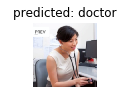

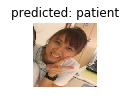

In [34]:
# Results from trained model with best validation accuracy of 89%
visualize_model(model_conv)
plt.ioff()
plt.show()